<a href="https://colab.research.google.com/github/Servat0r/Robotics-Project/blob/master/Robotics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Preliminary

In [1]:
%cd "/content/drive/MyDrive/Colab Notebooks"

/content/drive/MyDrive/Colab Notebooks


In [2]:
import numpy as np
import cv2
from PIL import Image
import os
import PIL
import tensorflow as tf
import tensorflow_datasets as tfds
import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### Utils

In [3]:
def plot_results(history: tf.keras.callbacks.History, n_epochs):
    fig, ax = plt.subplots(1, 1)
    epochs = np.arange(1, n_epochs+1)
    trainLoss, validationLoss = history.history['loss'], history.history['val_loss']
    ax.plot(epochs, trainLoss, label='Training Loss')
    ax.plot(epochs, validationLoss, label='Validation Loss')

### Dataset Retrieval
The original dataset is made up of $513$ `full-hd` ($1920 \times 1080$) images in `png` format. While in this format a single image requires $\approx 100$ KB of memory, a `numpy` array that contains the image in `float32` datatype will require at least $1920 \times 1080 \times 3 \times 4 \approx 24$ MB of memory, hence the whole dataset will require $\approx 12$ GB and would be unfeasible.

For simplicity, we then define a `get_dataset()` function that resizes all the images to a percentage of the original size through the `PIL.Image.Image.thumbnail()` method. By default we operate with a size of $240 \times 135$ ($12.5\%$ of original width and height values).

In [4]:
def get_dataset(
    image_data_path='data/image/ws_0.5', motion_data_path='data/motion/ws_0.5.npz',
    resize=True, force_resize=True, target_size_perc=0.125, rescale_coordinates=1,
    target_size=None,
  ): # by default 135 x 240
  if target_size:
    target_height, target_width = target_size
  else:
    target_height, target_width = int(1080 * target_size_perc), int(1920 * target_size_perc)
  resized_dir_path = os.path.join(image_data_path, f'resized_{target_height}x{target_width}')
  # Resizes images to given size
  if force_resize or (resize and not os.path.exists(resized_dir_path)):
    os.makedirs(resized_dir_path, exist_ok=True)
    pngs = sorted(list(glob.glob(f'{image_data_path}/*.png')))
    for i, png in enumerate(pngs):
      image = PIL.Image.open(png)
      image = image.resize((target_width, target_height))
      #image.thumbnail((target_width, target_height))
      image.save(os.path.join(resized_dir_path, f'{i}.png'), "PNG")
  pngs = sorted(list(glob.glob(f'{resized_dir_path}/*.png')), key=lambda x: int(x.split('/')[-1].split('.')[0]))
  images = np.zeros((len(pngs), target_height, target_width, 3), dtype=np.float32)
  for i, png in enumerate(pngs):
    images[i][:, :, :] = np.array(PIL.Image.open(png))
  motion_data = np.load(motion_data_path)
  tip_pos = rescale_coordinates * motion_data['position_rod1'][:, [2, 0, 1], -1]  # all positions of last node ([2,0,1] converts to xyz)
  return images / 255.0, tip_pos

Now a couple of hyperparameters:

In [5]:
batch_size = 32  #len(images)
resize_perc = 0.125
n_epochs = 100

In [6]:
images, tip_pos = get_dataset(target_size_perc=resize_perc, force_resize=False, rescale_coordinates=100)

Now we do *train-test split* with a validation percentage of $20\%$.

In [ ]:
train_images, eval_images, train_tip_pos, eval_tip_pos = train_test_split(images, tip_pos, test_size=0.2, random_state=0)

We now define a *VGG-like* initial CNN to experiment: $5$ *VGG-blocks* (two `Conv2D` and a `MaxPool2D` layers with a kernel size of $4$ and `relu` activation) and a flattening and final `Dense` block.

In [ ]:
model = tf.keras.Sequential([

  tf.keras.layers.Conv2D(8, kernel_size=4, activation='relu', padding='same', input_shape=(135, 240, 3)),
  #tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(8, kernel_size=4, activation='relu', padding='same'),
  #tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPool2D(),
  #tf.keras.layers.BatchNormalization(),
  #tf.keras.layers.Dropout(0.2),

  tf.keras.layers.Conv2D(16, kernel_size=4, activation='relu', padding='same'),
  #tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(16, kernel_size=4, activation='relu', padding='same'),
  #tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPool2D(),
  #tf.keras.layers.BatchNormalization(),
  #tf.keras.layers.Dropout(0.3),

  tf.keras.layers.Conv2D(32, kernel_size=4, activation='relu', padding='same'),
  #tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(32, kernel_size=4, activation='relu', padding='same'),
  #tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPool2D(),
  #tf.keras.layers.BatchNormalization(),
  #tf.keras.layers.Dropout(0.3),

  tf.keras.layers.Conv2D(64, kernel_size=4, activation='relu', padding='same'),
  #tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(64, kernel_size=4, activation='relu', padding='same'),
  #tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPool2D(),
  #tf.keras.layers.BatchNormalization(),
  #tf.keras.layers.Dropout(0.3),

  tf.keras.layers.Conv2D(128, kernel_size=4, activation='relu', padding='same'),
  #tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(128, kernel_size=4, activation='relu', padding='same'),
  #tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPool2D(),
  #tf.keras.layers.BatchNormalization(),
  #tf.keras.layers.Dropout(0.3),

  tf.keras.layers.Flatten(),
  #tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(units=256, activation='relu'),
  tf.keras.layers.Dense(units=50, activation='relu'),
  #tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(units=3, activation='linear')
])

In [ ]:
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 135, 240, 8)       392       
                                                                 
 conv2d_11 (Conv2D)          (None, 135, 240, 8)       1032      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 67, 120, 8)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 67, 120, 16)       2064      
                                                                 
 conv2d_13 (Conv2D)          (None, 67, 120, 16)       4112      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 33, 60, 16)       0         
 2D)                                                    

In [ ]:
history = model.fit(
    train_images, train_tip_pos, epochs=n_epochs,
    validation_data=(eval_images, eval_tip_pos),
    batch_size = batch_size, shuffle=True,
)

Epoch 1/100
13/13 [==============================] - 15s 108ms/step - loss: 79.4297 - val_loss: 44.1851
Epoch 2/100
13/13 [==============================] - 0s 16ms/step - loss: 43.9560 - val_loss: 38.0192
Epoch 3/100
13/13 [==============================] - 0s 16ms/step - loss: 42.7044 - val_loss: 37.3730
Epoch 4/100
13/13 [==============================] - 0s 16ms/step - loss: 41.8699 - val_loss: 37.5187
Epoch 5/100
13/13 [==============================] - 0s 17ms/step - loss: 41.7761 - val_loss: 38.5749
Epoch 6/100
13/13 [==============================] - 0s 16ms/step - loss: 41.8887 - val_loss: 40.6788
Epoch 7/100
13/13 [==============================] - 0s 16ms/step - loss: 43.2641 - val_loss: 39.7109
Epoch 8/100
13/13 [==============================] - 0s 16ms/step - loss: 43.5081 - val_loss: 41.0203
Epoch 9/100
13/13 [==============================] - 0s 16ms/step - loss: 42.5125 - val_loss: 37.4545
Epoch 10/100
13/13 [==============================] - 0s 16ms/step - loss: 42.67

Now we plot the obtained results:

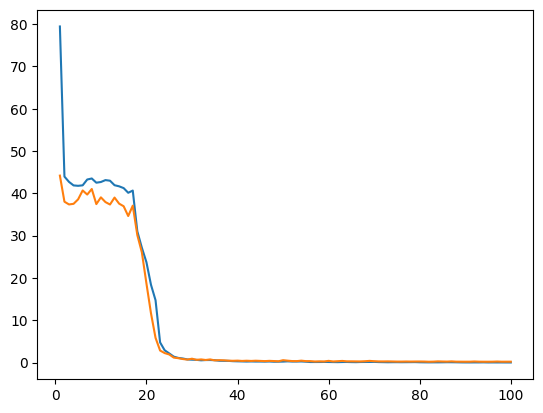

In [ ]:
%matplotlib inline
plot_results(history, n_epochs)

We now do a simple assessment on the quality of the predictions: given an input-output couple $(x, y = [y_1, y_2, y_3])$, if $\tilde{y}$ is the value predicted by the model, we calculate the relative error: $\left[\dfrac{|y_1 - \tilde{y_1} + \epsilon|}{|y_1 + \epsilon|}, \dfrac{|y_2 - \tilde{y_2} + \epsilon|}{|y_2 + \epsilon|}, \dfrac{|y_3 - \tilde{y_3} + \epsilon|}{|y_3 + \epsilon|}\right]$, where $\epsilon = 10^{-8}$ is a small constant to avoid dividing by $0$.

In [ ]:
epsilon = 1e-8
predictions = model.predict(eval_images)
differences = np.abs(predictions - eval_tip_pos - epsilon)
relative_errors = differences / np.abs(eval_tip_pos + epsilon)
relative_errors_x = relative_errors[:, 0]
relative_errors_y = relative_errors[:, 1]
relative_errors_z = relative_errors[:, 2]
print(len(relative_errors_x), len(relative_errors_y), len(relative_errors_z))
# Prune the cases of a zero target (multiplies by 10**6 the error)
relative_errors_x = relative_errors_x[eval_tip_pos[:, 0] != 0]
relative_errors_y = relative_errors_y[eval_tip_pos[:, 1] != 0]
relative_errors_z = relative_errors_z[eval_tip_pos[:, 2] != 0]
print(len(relative_errors_x), len(relative_errors_y), len(relative_errors_z))

4/4 [==============================] - 0s 6ms/step
103 103 103
102 102 103


(array([37., 18., 22.,  3.,  2.,  2.,  3.,  2.,  0.,  2.,  1.,  1.,  1.,
         1.,  1.,  0.,  0.,  0.,  1.]),
 array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
        0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
        0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
        0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ]),
 <BarContainer object of 19 artists>)

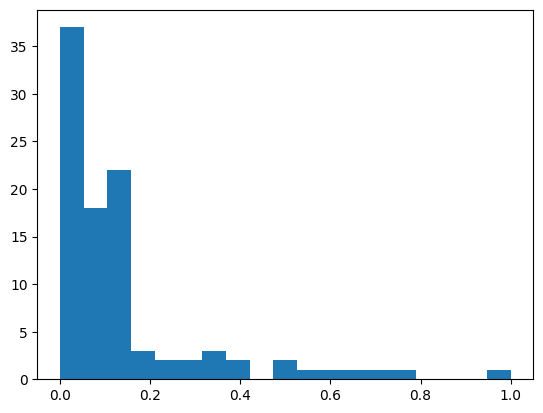

In [ ]:
%matplotlib inline
plt.hist(relative_errors_x, bins=np.linspace(0, 1, 20))

(array([75., 18.,  3.,  0.,  3.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  1.,  0.]),
 array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
        0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
        0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
        0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ]),
 <BarContainer object of 19 artists>)

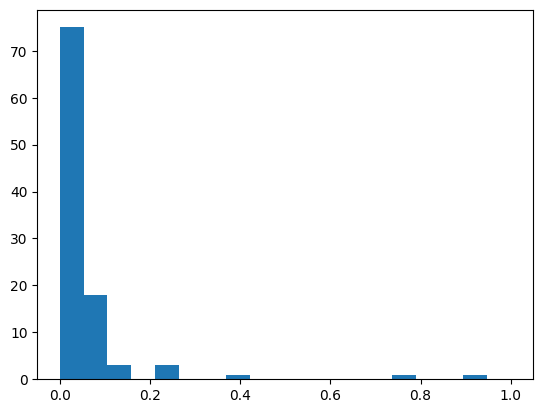

In [ ]:
%matplotlib inline
plt.hist(relative_errors_y, bins=np.linspace(0, 1, 20))

(array([103.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
 array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
        0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
        0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
        0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ]),
 <BarContainer object of 19 artists>)

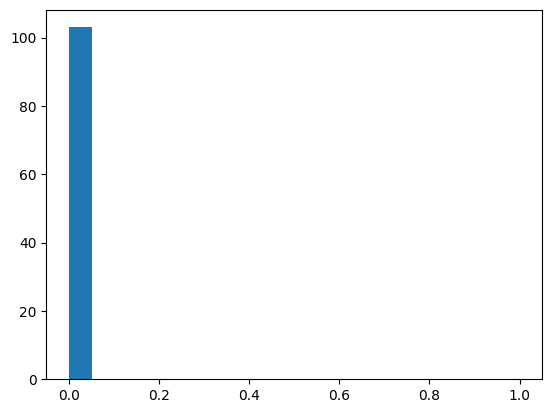

In [ ]:
%matplotlib inline
plt.hist(relative_errors_z, bins=np.linspace(0, 1, 20))

### Fine-Tuning a pretrained VGG

In [14]:
%matplotlib inline
images, tip_pos = get_dataset(target_size=(224, 224), force_resize=False, rescale_coordinates=100)

(513, 224, 224, 3) float32


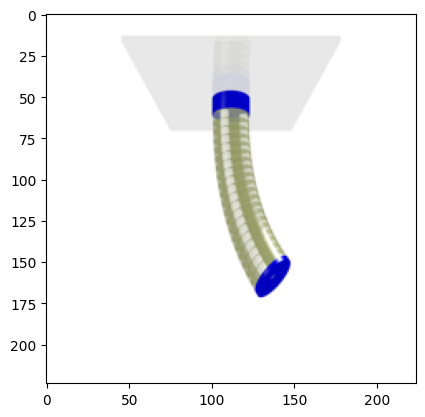

In [15]:
print(images.shape, images.dtype)
plt.imshow(PIL.Image.fromarray((255 * images[12]).astype(np.uint8)))

In [16]:
train_images, eval_images, train_tip_pos, eval_tip_pos = train_test_split(images, tip_pos, test_size=0.2, random_state=0)

In [17]:
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
)
base_model.trainable = False

In [18]:
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(3, activation='linear')(x)
finetuned_vgg_model = tf.keras.Model(inputs, outputs)

In [19]:
finetuned_vgg_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_1 (Dense)             (None, 3)                 75267     
                                                                 
Total params: 14,789,955
Trainable params: 75,267
Non-trainable params: 14,714,688
_________________________________________________________________


In [20]:
finetuned_vgg_model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))

In [21]:
finetuned_vgg_history = finetuned_vgg_model.fit(
    train_images, train_tip_pos, epochs=n_epochs,
    validation_data=(eval_images, eval_tip_pos),
    batch_size = batch_size, shuffle=True,
)

Epoch 1/100
13/13 [==============================] - 1s 56ms/step - loss: 54.8406 - val_loss: 29.2767
Epoch 2/100
13/13 [==============================] - 0s 32ms/step - loss: 17.4460 - val_loss: 14.7495
Epoch 3/100
13/13 [==============================] - 0s 32ms/step - loss: 9.3956 - val_loss: 6.4674
Epoch 4/100
13/13 [==============================] - 0s 32ms/step - loss: 4.8890 - val_loss: 4.0506
Epoch 5/100
13/13 [==============================] - 0s 32ms/step - loss: 3.2037 - val_loss: 2.3651
Epoch 6/100
13/13 [==============================] - 0s 32ms/step - loss: 1.9724 - val_loss: 1.4258
Epoch 7/100
13/13 [==============================] - 0s 32ms/step - loss: 1.4843 - val_loss: 1.0598
Epoch 8/100
13/13 [==============================] - 0s 32ms/step - loss: 1.2503 - val_loss: 0.9558
Epoch 9/100
13/13 [==============================] - 0s 32ms/step - loss: 1.0133 - val_loss: 0.7321
Epoch 10/100
13/13 [==============================] - 0s 32ms/step - loss: 0.8191 - val_loss: 0.

In [22]:
epsilon = 1e-8
predictions = finetuned_vgg_model.predict(eval_images)
differences = np.abs(predictions - eval_tip_pos - epsilon)
relative_errors = differences / np.abs(eval_tip_pos + epsilon)
relative_errors_x = relative_errors[:, 0]
relative_errors_y = relative_errors[:, 1]
relative_errors_z = relative_errors[:, 2]
print(len(relative_errors_x), len(relative_errors_y), len(relative_errors_z))
# Prune the cases of a zero target (multiplies by 10**6 the error)
relative_errors_x = relative_errors_x[eval_tip_pos[:, 0] != 0]
relative_errors_y = relative_errors_y[eval_tip_pos[:, 1] != 0]
relative_errors_z = relative_errors_z[eval_tip_pos[:, 2] != 0]
print(len(relative_errors_x), len(relative_errors_y), len(relative_errors_z))

4/4 [==============================] - 0s 23ms/step
103 103 103
102 102 103


(array([57., 17.,  9.,  5.,  4.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,
         1.,  1.,  0.,  0.,  0.,  1.]),
 array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
        0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
        0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
        0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ]),
 <BarContainer object of 19 artists>)

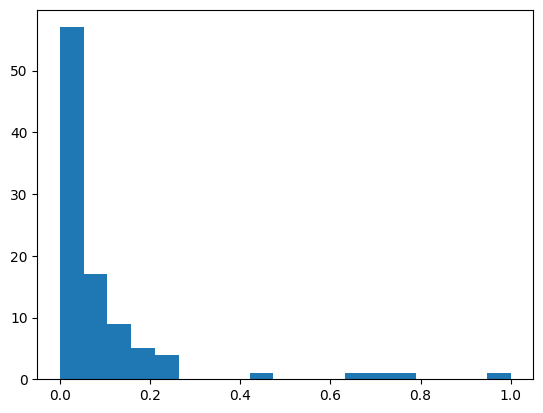

In [23]:
%matplotlib inline
plt.hist(relative_errors_x, bins=np.linspace(0, 1, 20))

(array([75., 13.,  6.,  3.,  0.,  0.,  2.,  0.,  1.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.]),
 array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
        0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
        0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
        0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ]),
 <BarContainer object of 19 artists>)

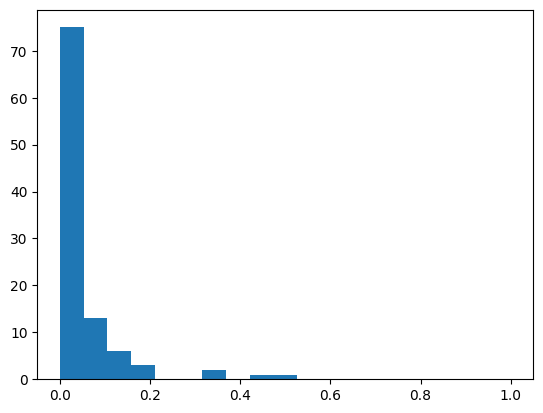

In [24]:
%matplotlib inline
plt.hist(relative_errors_y, bins=np.linspace(0, 1, 20))

(array([103.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
 array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
        0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
        0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
        0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ]),
 <BarContainer object of 19 artists>)

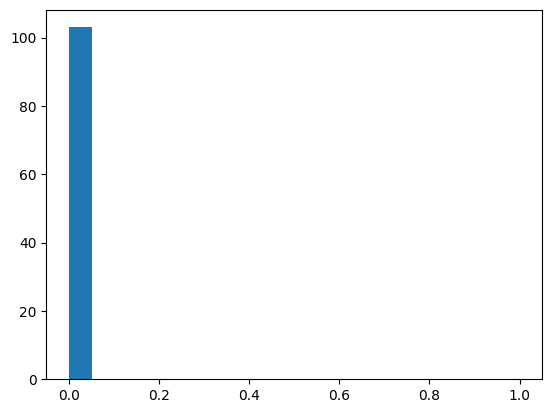

In [25]:
%matplotlib inline
plt.hist(relative_errors_z, bins=np.linspace(0, 1, 20))

### Data Augmentation
We start with a simple `Data Augmentation` technique consisting in horizontally flipping the image. Remember that in this dataset, the camera is aligned to the `x`-axis, flipping the image to the right actually changes only the value of $y \rightarrow -y$.

In [ ]:
def apply_horizontal_flip(images, tip_pos):
  flipped_images = np.flip(images, axis=2)
  flipped_tip_pos = tip_pos.copy()
  flipped_tip_pos[:, 1] = -flipped_tip_pos[:, 1]
  return np.r_[images, flipped_images], np.r_[tip_pos, flipped_tip_pos]

In [ ]:
images, tip_pos = apply_horizontal_flip(images, tip_pos)

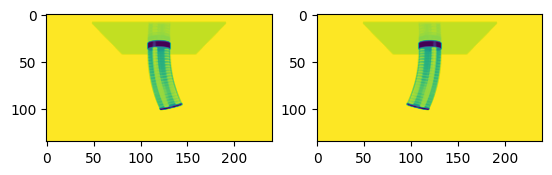

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(1, 2)
ax[0].imshow(images[10, :, :, 1])
ax[1].imshow(images[513+10, :, :, 1])

In [ ]:
train_images, eval_images, train_tip_pos, eval_tip_pos = train_test_split(images, tip_pos, test_size=0.2, random_state=0)

In [ ]:
model2 = tf.keras.Sequential([

  tf.keras.layers.Conv2D(8, kernel_size=4, activation='relu', padding='same', input_shape=(135, 240, 3)),
  #tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(8, kernel_size=4, activation='relu', padding='same'),
  #tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPool2D(),
  #tf.keras.layers.BatchNormalization(),
  #tf.keras.layers.Dropout(0.2),

  tf.keras.layers.Conv2D(16, kernel_size=4, activation='relu', padding='same'),
  #tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(16, kernel_size=4, activation='relu', padding='same'),
  #tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPool2D(),
  #tf.keras.layers.BatchNormalization(),
  #tf.keras.layers.Dropout(0.3),

  tf.keras.layers.Conv2D(32, kernel_size=4, activation='relu', padding='same'),
  #tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(32, kernel_size=4, activation='relu', padding='same'),
  #tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPool2D(),
  #tf.keras.layers.BatchNormalization(),
  #tf.keras.layers.Dropout(0.3),

  tf.keras.layers.Conv2D(64, kernel_size=4, activation='relu', padding='same'),
  #tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(64, kernel_size=4, activation='relu', padding='same'),
  #tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPool2D(),
  #tf.keras.layers.BatchNormalization(),
  #tf.keras.layers.Dropout(0.3),

  tf.keras.layers.Conv2D(128, kernel_size=4, activation='relu', padding='same'),
  #tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(128, kernel_size=4, activation='relu', padding='same'),
  #tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPool2D(),
  #tf.keras.layers.BatchNormalization(),
  #tf.keras.layers.Dropout(0.3),

  tf.keras.layers.Flatten(),
  #tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(units=256, activation='relu'),
  tf.keras.layers.Dense(units=50, activation='relu'),
  #tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(units=3, activation='linear')
])

In [ ]:
model2.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))

In [ ]:
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 135, 240, 8)       392       
                                                                 
 conv2d_43 (Conv2D)          (None, 135, 240, 8)       1032      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 67, 120, 8)       0         
 g2D)                                                            
                                                                 
 conv2d_44 (Conv2D)          (None, 67, 120, 16)       2064      
                                                                 
 conv2d_45 (Conv2D)          (None, 67, 120, 16)       4112      
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 33, 60, 16)       0         
 g2D)                                                 

In [ ]:
history2 = model2.fit(
    train_images, train_tip_pos, epochs=n_epochs,
    validation_data=(eval_images, eval_tip_pos),
    batch_size = batch_size, shuffle=True,
)

Epoch 1/100
26/26 [==============================] - 5s 25ms/step - loss: 127.1975 - val_loss: 49.7722
Epoch 2/100
26/26 [==============================] - 0s 15ms/step - loss: 43.8330 - val_loss: 41.7589
Epoch 3/100
26/26 [==============================] - 0s 15ms/step - loss: 40.9921 - val_loss: 41.1363
Epoch 4/100
26/26 [==============================] - 0s 15ms/step - loss: 40.5735 - val_loss: 41.0821
Epoch 5/100
26/26 [==============================] - 0s 15ms/step - loss: 40.5066 - val_loss: 41.2482
Epoch 6/100
26/26 [==============================] - 0s 15ms/step - loss: 40.6755 - val_loss: 42.1754
Epoch 7/100
26/26 [==============================] - 0s 15ms/step - loss: 41.2835 - val_loss: 40.7855
Epoch 8/100
26/26 [==============================] - 0s 15ms/step - loss: 40.7691 - val_loss: 41.3692
Epoch 9/100
26/26 [==============================] - 0s 15ms/step - loss: 41.4245 - val_loss: 42.6746
Epoch 10/100
26/26 [==============================] - 0s 15ms/step - loss: 40.678

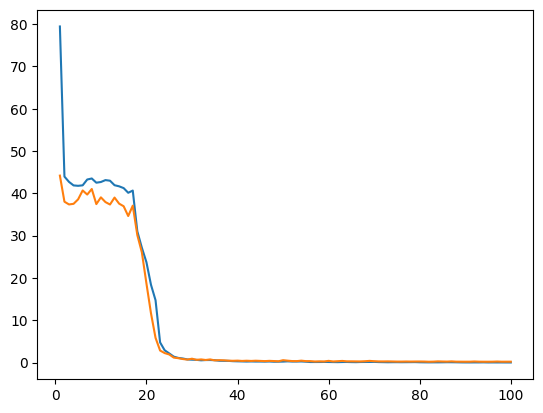

In [ ]:
%matplotlib inline
plot_results(history, n_epochs)

In [ ]:
epsilon = 1e-8
predictions2 = model.predict(eval_images)
differences2 = np.abs(predictions2 - eval_tip_pos - epsilon)
relative_errors2 = differences2 / np.abs(eval_tip_pos + epsilon)
relative_errors2_x = relative_errors2[:, 0]
relative_errors2_y = relative_errors2[:, 1]
relative_errors2_z = relative_errors2[:, 2]
print(len(relative_errors2_x), len(relative_errors2_y), len(relative_errors2_z))
# Prune the cases of a zero target (multiplies by 10**6 the error)
relative_errors2_x = relative_errors2_x[eval_tip_pos[:, 0] != 0]
relative_errors2_y = relative_errors2_y[eval_tip_pos[:, 1] != 0]
relative_errors2_z = relative_errors2_z[eval_tip_pos[:, 2] != 0]
print(len(relative_errors2_x), len(relative_errors2_y), len(relative_errors2_z))

7/7 [==============================] - 0s 6ms/step
206 206 206
205 205 206


(array([83., 31., 26., 12.,  8.,  8.,  8.,  1.,  3.,  3.,  0.,  1.,  0.,
         1.,  1.,  0.,  0.,  0.,  0.]),
 array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
        0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
        0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
        0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ]),
 <BarContainer object of 19 artists>)

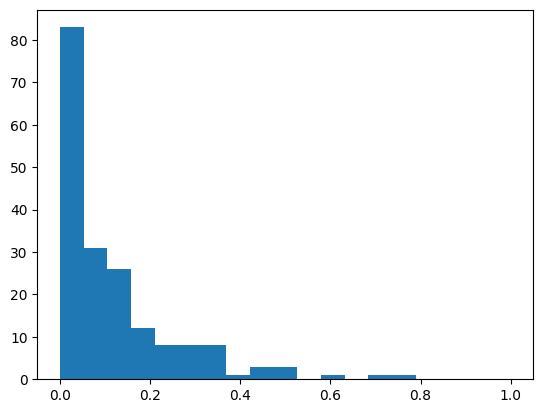

In [ ]:
%matplotlib inline
plt.hist(relative_errors2_x, bins=np.linspace(0, 1, 20))

(array([125.,  33.,  16.,   7.,   2.,   2.,   3.,   2.,   2.,   2.,   1.,
          0.,   1.,   0.,   1.,   2.,   0.,   1.,   0.]),
 array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
        0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
        0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
        0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ]),
 <BarContainer object of 19 artists>)

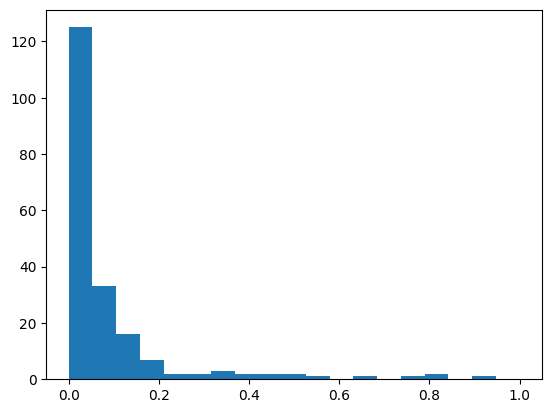

In [ ]:
%matplotlib inline
plt.hist(relative_errors2_y, bins=np.linspace(0, 1, 20))

(array([176.,  29.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
 array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
        0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
        0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
        0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ]),
 <BarContainer object of 19 artists>)

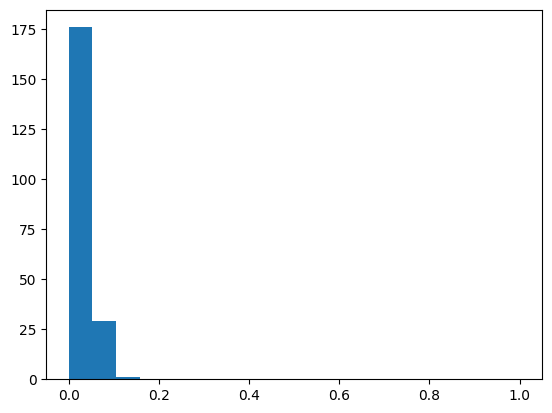

In [ ]:
%matplotlib inline
plt.hist(relative_errors2_z, bins=np.linspace(0, 1, 20))